In [1]:
import pandas as pd
import pingouin as pg
import lightgbm as lgb
import numpy as np
import shap
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

csv_path = 'outlier_removed.csv'    # 여기에 absolute path
# CSV 읽기
df = pd.read_csv(
    csv_path,
    header=0,        # 첫 줄을 컬럼명으로 사용
    index_col='id',  # 인덱스 컬럼으로 id 지정
    encoding='utf-8-sig'
)
# 데이터 확인
df

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,host_is_superhost,host_has_profile_pic,host_identity_verified,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_ny,host_location_boolean,log_price,room_new_type
id,,,,,,,,,,,,,,,,,,,,,
36121,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,0,1,1,4.0,4,4,1,1,5.303305,mid
36647,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,0,1,1,4.0,4,4,1,1,4.418841,upper-mid
38663,Boerum Hill,Brooklyn,40.684420,-73.980680,765.0,0,0.0,49,326,0,...,0,1,1,3.0,4,2,1,1,6.641182,low-mid
38833,Harlem,Manhattan,40.818058,-73.946671,139.0,255,35445.0,18,25,0,...,1,1,1,4.0,4,4,1,1,4.941642,low-mid
39282,Williamsburg,Brooklyn,40.710651,-73.950874,130.0,154,20020.0,22,38,0,...,1,1,1,4.0,4,4,1,1,4.875197,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366333532374850165,Harlem,Manhattan,40.813794,-73.952399,72.0,0,0.0,53,358,0,...,0,1,1,4.0,4,4,1,1,4.290459,mid
1366717321390111215,Bedford-Stuyvesant,Brooklyn,40.685500,-73.919510,58.0,0,0.0,58,363,0,...,1,1,1,4.0,4,4,1,1,4.077537,mid
1366721904709517353,Kips Bay,Manhattan,40.745290,-73.979380,299.0,0,0.0,39,99,0,...,0,1,1,4.0,4,4,0,1,5.703782,mid


In [2]:
import time
import json
import requests
import geopandas as gpd
from shapely.geometry import Point
# ─────────────────────────────────────────────────────────────────────────────
# 0) 원본 df, poi_tags, 그리고 bbox 계산
  # latitude, longitude 칼럼이 있어야 함
poi_tags = {
    'transport': {
        'amenity': ['bus_station','taxi'],
        'railway': ['station']
    },
    'infrastructure': {
        'amenity': ['police','hospital','pharmacy','restaurant','supermarket']
    },
    'tourism': {
        'tourism': ['viewpoint','museum','attraction'],
        'leisure': ['park']
    }
}
pad = 0.01
minx, maxx = df.longitude.min()-pad, df.longitude.max()+pad
miny, maxy = df.latitude.min()-pad, df.latitude.max()+pad
# ─────────────────────────────────────────────────────────────────────────────
# 1) 한 번에 bbox 내 모든 POI 내려받기 (Overpass bbox 쿼리)
OVERPASS_URL = "http://overpass-api.de/api/interpreter"
# build filters for bbox query
filters = ""
for grp in poi_tags.values():
    for key, vals in grp.items():
        for v in vals:
            filters += f'node["{key}"="{v}"]({miny},{minx},{maxy},{maxx});\n'
# full query
query = f"""
[out:json][timeout:180];
(
{filters}
);
out body;
"""
resp = requests.post(OVERPASS_URL, data={'data': query}, timeout=(5,300))
resp.raise_for_status()
data = resp.json().get('elements', [])
# ─────────────────────────────────────────────────────────────────────────────
# 2) GeoDataFrame 생성
pois = pd.DataFrame([
    {
      'lon': el['lon'],
      'lat': el['lat'],
      **el.get('tags',{})
    }
    for el in data
    if el['type']=='node' and 'lon' in el
])
gdf_pois = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(pois.lon, pois.lat),
    crs="EPSG:4326"
).to_crs(epsg=3857)
# 원본 좌표도 GeoDataFrame
gdf_pts = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
).to_crs(epsg=3857)
sindex = gdf_pois.sindex
# ─────────────────────────────────────────────────────────────────────────────
# 3) 그룹별 카운트 함수
def count_group(pt, grp_map, radius=1000):
    buf = pt.buffer(radius)
    candidates = gdf_pois.iloc[list(sindex.intersection(buf.bounds))]
    cnt = 0
    for key, vals in grp_map.items():
        cnt += candidates[candidates[key].isin(vals)].shape[0]
    return cnt
# 4) 각 포인트별 count, df에 붙이기
for grp, tags in poi_tags.items():
    df[f"{grp}_count"] = [
        count_group(pt, tags, radius=1000)
        for pt in gdf_pts.geometry
    ]
# 5) 결과 확인
print(df[['transport_count','infrastructure_count','tourism_count']].head())

       transport_count  infrastructure_count  tourism_count
id                                                         
36121                7                    77              1
36647                3                    79              4
38663               11                   109              2
38833                4                    34              2
39282                7                   117              1


In [3]:
df

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_ny,host_location_boolean,log_price,room_new_type,transport_count,infrastructure_count,tourism_count
id,,,,,,,,,,,,,,,,,,,,,
36121,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,4.0,4,4,1,1,5.303305,mid,7,77,1
36647,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,4.0,4,4,1,1,4.418841,upper-mid,3,79,4
38663,Boerum Hill,Brooklyn,40.684420,-73.980680,765.0,0,0.0,49,326,0,...,3.0,4,2,1,1,6.641182,low-mid,11,109,2
38833,Harlem,Manhattan,40.818058,-73.946671,139.0,255,35445.0,18,25,0,...,4.0,4,4,1,1,4.941642,low-mid,4,34,2
39282,Williamsburg,Brooklyn,40.710651,-73.950874,130.0,154,20020.0,22,38,0,...,4.0,4,4,1,1,4.875197,mid,7,117,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366333532374850165,Harlem,Manhattan,40.813794,-73.952399,72.0,0,0.0,53,358,0,...,4.0,4,4,1,1,4.290459,mid,4,58,4
1366717321390111215,Bedford-Stuyvesant,Brooklyn,40.685500,-73.919510,58.0,0,0.0,58,363,0,...,4.0,4,4,1,1,4.077537,mid,4,27,1
1366721904709517353,Kips Bay,Manhattan,40.745290,-73.979380,299.0,0,0.0,39,99,0,...,4.0,4,4,0,1,5.703782,mid,8,276,6


In [4]:
from sklearn.decomposition import PCA
poi_cols = ['transport_count','infrastructure_count','tourism_count']
pca = PCA(n_components=1)
# PCA fit → PC1 점수 생성
df['poi_pca1'] = pca.fit_transform(df[poi_cols].fillna(0))
# 설명 분산 비율 확인 (얼마나 데이터의 변동성을 담았는지)
print("Explained variance ratio (PC1):", pca.explained_variance_ratio_[0])
#poi_pca1 <0 poi 희박 지역, poi_pca1 > 0 poi 밀집지역

Explained variance ratio (PC1): 0.9981724847022044


In [6]:
# 위치데이터 카운트 변수들 정규성/등분산성

from scipy.stats import shapiro, levene

Location = ['transport_count', 'infrastructure_count', 'tourism_count', 'poi_pca1']
TARGET = 'host_is_superhost'

for col in Location:
    print(f"\n 변수: {col}")

    # 정규성 검정 (랜덤 샘플링)
    group1 = df[df[TARGET]==1][col].dropna()
    group0 = df[df[TARGET]==0][col].dropna()
    
    n1 = min(5000, len(group1))
    n0 = min(5000, len(group0))

    stat1, p1 = shapiro(group1.sample(n1, random_state=42))
    stat0, p0 = shapiro(group0.sample(n0, random_state=42))

    print(f"정규성 p값 (group1): {p1:.4f}, (group0): {p0:.4f}")

    # 등분산성 검정
    stat, p = levene(group1, group0)
    print(f"등분산성 p값: {p:.4f}")



 변수: transport_count
정규성 p값 (group1): 0.0000, (group0): 0.0000
등분산성 p값: 0.0000

 변수: infrastructure_count
정규성 p값 (group1): 0.0000, (group0): 0.0000
등분산성 p값: 0.0000

 변수: tourism_count
정규성 p값 (group1): 0.0000, (group0): 0.0000
등분산성 p값: 0.0000

 변수: poi_pca1
정규성 p값 (group1): 0.0000, (group0): 0.0000
등분산성 p값: 0.0000


In [ ]:
# 장소 변수별 비모수 검정 
from scipy.stats import mannwhitneyu

for col in Location:
    group1 = df[df[TARGET]==1][col].dropna()
    group0 = df[df[TARGET]==0][col].dropna()

    stat, p = mannwhitneyu(group1, group0, alternative='two-sided')
    print(f"{col} - Mann-Whitney U p값: {p:.4f}")

transport_count - Mann-Whitney U p값: 0.0000
infrastructure_count - Mann-Whitney U p값: 0.0000
tourism_count - Mann-Whitney U p값: 0.0000
poi_pca1 - Mann-Whitney U p값: 0.0000


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# X, y 분리
X = df[Location]
y = df[TARGET].astype(int)

# 학습용/테스트용 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 학습
logit = LogisticRegression(max_iter=1000, class_weight='balanced')
logit.fit(X_train, y_train)

# 예측
y_pred = logit.predict(X_test)
y_prob = logit.predict_proba(X_test)[:, 1]

# 평가
print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred))
print("AUC:", round(roc_auc_score(y_test, y_prob), 4))



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.78      0.38      0.51      3235
           1       0.30      0.72      0.43      1227

    accuracy                           0.47      4462
   macro avg       0.54      0.55      0.47      4462
weighted avg       0.65      0.47      0.49      4462

AUC: 0.5597


In [19]:
from sklearn.ensemble import RandomForestClassifier

# X, y 분리
X = df[Location]
y = df[TARGET].astype(int)

rf = RandomForestClassifier(
    n_estimators=2000,  # 더 많은 트리
    max_depth=30,      # 최대 깊이 제한
    min_samples_split=15,  # 노드 분할 최소 샘플 수
    min_samples_leaf=10,    # 리프 노드 최소 샘플 수
    random_state=42,
    class_weight='balanced')

# 학습용/테스트용 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 학습
rf.fit(X_train, y_train)

# 예측
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# 평가
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred))
print("AUC:", round(roc_auc_score(y_test, y_prob), 4))



=== Random Forest ===
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      3235
           1       0.37      0.51      0.43      1227

    accuracy                           0.63      4462
   macro avg       0.58      0.59      0.58      4462
weighted avg       0.67      0.63      0.64      4462

AUC: 0.6499


In [20]:
# 변수 중요도
importances_rf = pd.Series(rf.feature_importances_, index=Location)
print("\n=== Random Forest 변수 중요도 ===")
print(importances_rf.sort_values(ascending=False))


=== Random Forest 변수 중요도 ===
poi_pca1                0.425864
infrastructure_count    0.259179
transport_count         0.166048
tourism_count           0.148909
dtype: float64


In [ ]:
#Location 중앙값, 평균차

# 중앙값 테이블
Location_median = pd.DataFrame({
    'variable': Location,
    'superhost_median': [df[df['host_is_superhost'] == 1][col].median() for col in Location],
    'non_superhost_median': [df[df['host_is_superhost'] == 0][col].median() for col in Location]})

# 평균값 테이블 
Location_median_avg = pd.DataFrame({
    'variable': Location,
    'superhost_avg': [df[df['host_is_superhost'] == 1][col].mean().round(2) for col in Location],
    'non_superhost_avg': [df[df['host_is_superhost'] == 0][col].mean().round(2) for col in Location]})
 
# 평균 + 중앙값 테이블 합치기
Location_merged = pd.merge(Location_median_avg,Location_median,on='variable')

# 차이 컬럼 추가
Location_merged['mean_diff'] = (Location_merged['superhost_avg'] - Location_merged['non_superhost_avg']).round(2)
Location_merged['median_diff'] = (Location_merged['superhost_median'] - Location_merged['non_superhost_median']).round(2)

# 차이 기준 정렬
Location_merged.sort_values('mean_diff', ascending=False)

,variable,superhost_avg,non_superhost_avg,superhost_median,non_superhost_median,mean_diff,median_diff
2,tourism_count,3.49,4.62,2.000000,3.000000,-1.13,-1.00
0,transport_count,5.15,6.37,4.000000,4.000000,-1.22,0.00
1,infrastructure_count,100.54,127.65,63.000000,82.000000,-27.11,-19.00
3,poi_pca1,-19.69,7.47,-57.262691,-38.392555,-27.16,-18.87


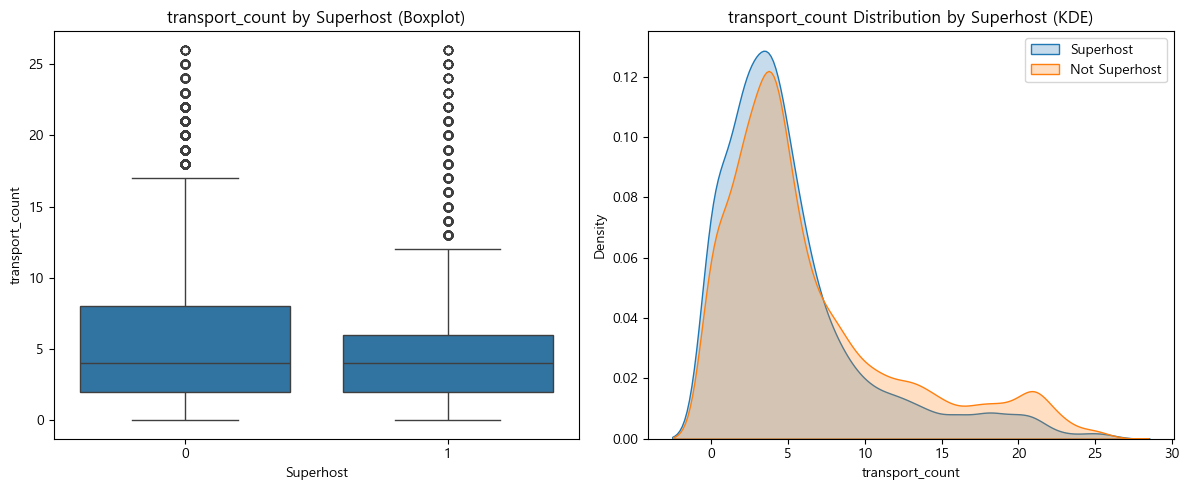

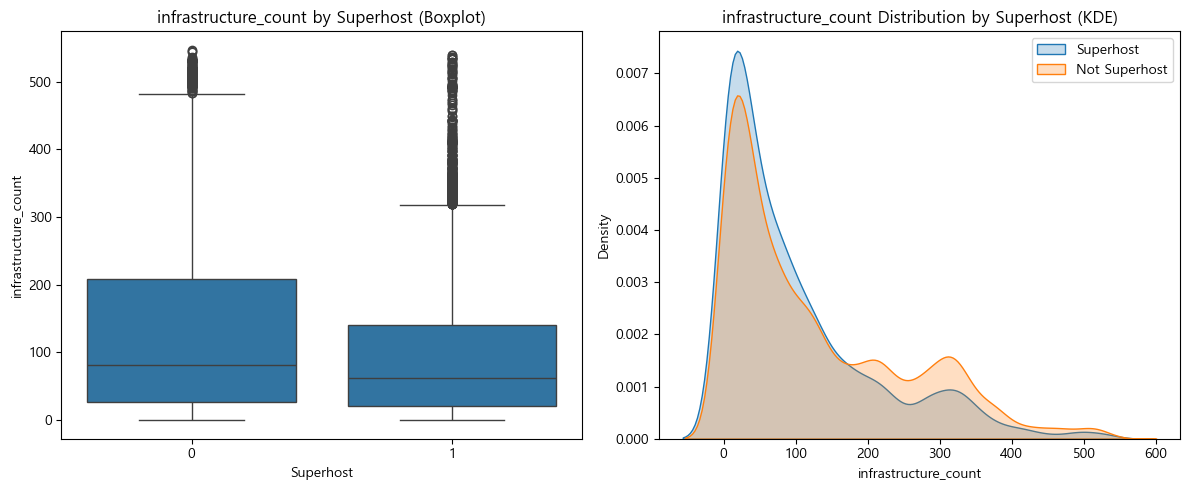

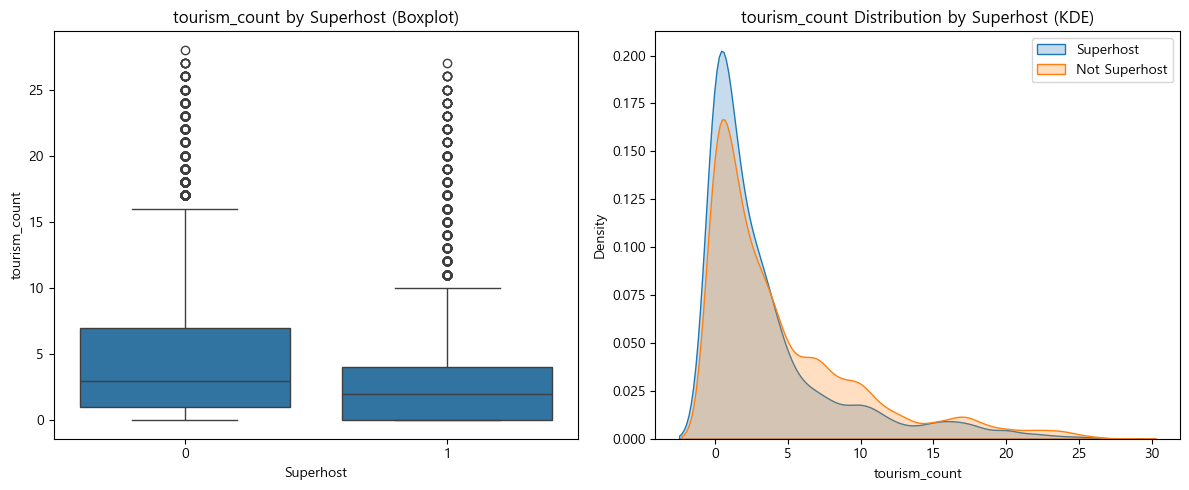

C:\Users\HY\AppData\Local\Temp\ipykernel_4660\3622722193.py:21: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\HY\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


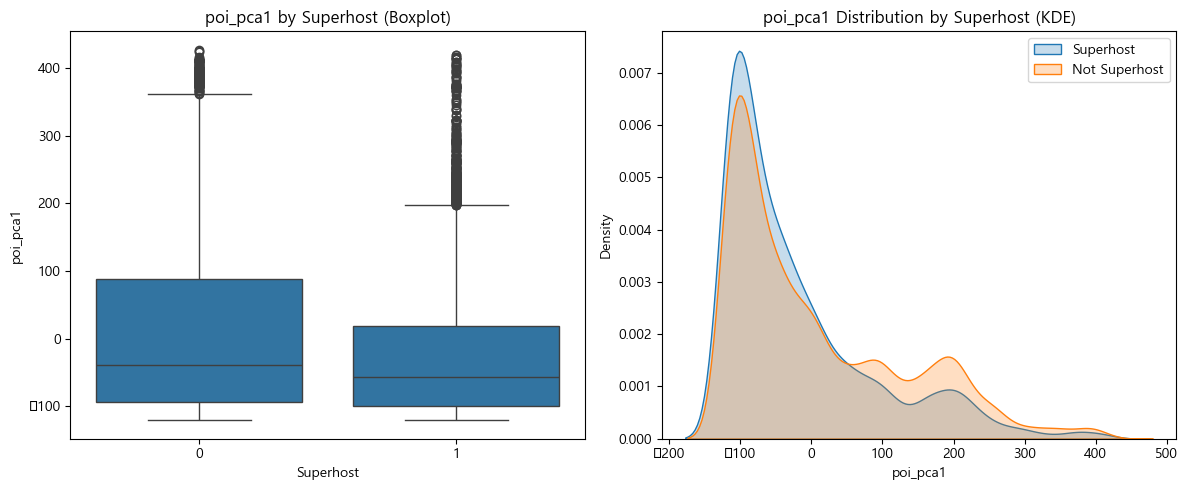

In [53]:
# 박스플롯 & 커널밀도 히스토그램 (각 변수별 슈퍼호스트 유무 분포)
import seaborn as sns
import matplotlib.pyplot as plt
location_vars = ['transport_count', 'infrastructure_count', 'tourism_count','poi_pca1']

for var in location_vars:
    plt.figure(figsize=(12, 5))

    # 박스플롯
    plt.subplot(1, 2, 1)
    sns.boxplot(x='host_is_superhost', y=var, data=df)
    plt.title(f'{var} by Superhost (Boxplot)')
    plt.xlabel('Superhost')
    plt.ylabel(var)

    # 히스토그램 + 커널밀도
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df[df['host_is_superhost'] == 1], x=var, label='Superhost', fill=True)
    sns.kdeplot(data=df[df['host_is_superhost'] == 0], x=var, label='Not Superhost', fill=True)
    plt.title(f'{var} Distribution by Superhost (KDE)')
    plt.xlabel(var)
    plt.legend()

    plt.tight_layout()
    plt.show()

| 변수                        | 슈퍼호스트 vs 비슈퍼호스트                 | 해석                                      |
| ------------------------- | ------------------------------- | --------------------------------------- |
| **tourism\_count**        | 슈퍼호스트: 3.49 vs 비슈퍼호스트: 4.62     | **관광 시설이 적은 곳에서 슈퍼호스트 비율이 높음**          |
| **transport\_count**      | 슈퍼호스트: 5.15 vs 비슈퍼호스트: 6.37     | **교통 시설이 적은 곳에서 슈퍼호스트 비율이 높음**          |
| **infrastructure\_count** | 슈퍼호스트: 100.54 vs 비슈퍼호스트: 127.65 | **기반 시설이 적은 곳에서 슈퍼호스트 비율이 높음**          |
| **poi\_pca1**             | 슈퍼호스트: -19.69 vs 비슈퍼호스트: 7.47   | **poi\_pca1 값이 매우 낮은 곳에서 슈퍼호스트 비율이 높음** |

1. 일반적으로 인프라가 좋은 곳에 슈퍼호스트가 많다 일줄알았는데 반대인 데이터값 

실제 Airbnb 슈퍼호스트 시스템은 경쟁, 리뷰, 운영 방식에 더 큰 영향을 받을 수 있음

예를 들어, 인프라가 좋은 지역은 경쟁이 치열해서 슈퍼호스트로 살아남기 어려울 수 있음.

반대로 인프라가 조금 부족하더라도 서비스가 좋고 리뷰가 좋아서 슈퍼호스트가 되는 경우도 많음.

2. 슈퍼호스트가 상대적으로 "비주류 지역"에 더 많을 수도 있음
인프라가 좋은 곳은 이미 호텔, 대형 숙소, 상업적 플레이어들이 많을 수 있음.
그런 곳에서는 오히려 개인 호스트가 슈퍼호스트 되기 어려울 수 있음.
반면, 관광지 주변이나 교통은 조금 부족해도 지역적 특색이 있는 곳에서는 열심히 운영하는 개인 호스트가 눈에 띄고 슈퍼호스트가 될 확률이 높을 수도 있음.

In [80]:
# median 기준 High/Low로 나눔
location_vars = ['transport_count', 'infrastructure_count', 'tourism_count', 'poi_pca1']
review_median = df['review_scores_rating'].median()

for loc_var in location_vars:
    # 기준값 구하기
    loc_median = df[loc_var].median()
    
    # 레벨 구분
    df['loc_level'] = df[loc_var].apply(lambda x: 'Low' if x < loc_median else 'High')
    df['review_level'] = df['review_scores_rating'].apply(lambda x: 'Low' if x < review_median else 'High')
    
    # 그룹명 생성
    df['group'] = df['loc_level'] + f' {loc_var} & ' + df['review_level'] + ' Review'
    
    # 교차표 생성
    group_summary = pd.crosstab(
        df['group'],
        df['host_is_superhost'],
        normalize='index'
    ).round(3)
    
    group_summary.columns = ['Not Superhost', 'Superhost']
    group_summary = group_summary.sort_values(by='Superhost', ascending=False)
    
    # 결과 출력
    print(f'\n Superhost Ratio for Location Variable: **{loc_var}**')
    print(group_summary)
print(group_summary)


 Superhost Ratio for Location Variable: **transport_count**
                                    Not Superhost  Superhost
group                                                       
Low transport_count & High Review           0.654      0.346
High transport_count & High Review          0.714      0.286
Low transport_count & Low Review            0.820      0.180
High transport_count & Low Review           0.867      0.133

 Superhost Ratio for Location Variable: **infrastructure_count**
                                         Not Superhost  Superhost
group                                                            
Low infrastructure_count & High Review           0.654      0.346
High infrastructure_count & High Review          0.727      0.273
Low infrastructure_count & Low Review            0.848      0.152
High infrastructure_count & Low Review           0.851      0.149

 Superhost Ratio for Location Variable: **tourism_count**
                                  Not Superhost  Sup

인프라가 낮아도 리뷰수가 많으면 슈퍼호스트 일 확률이 더 높아진다 

C:\Users\HY\AppData\Local\Temp\ipykernel_4660\1185838175.py:25: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\HY\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


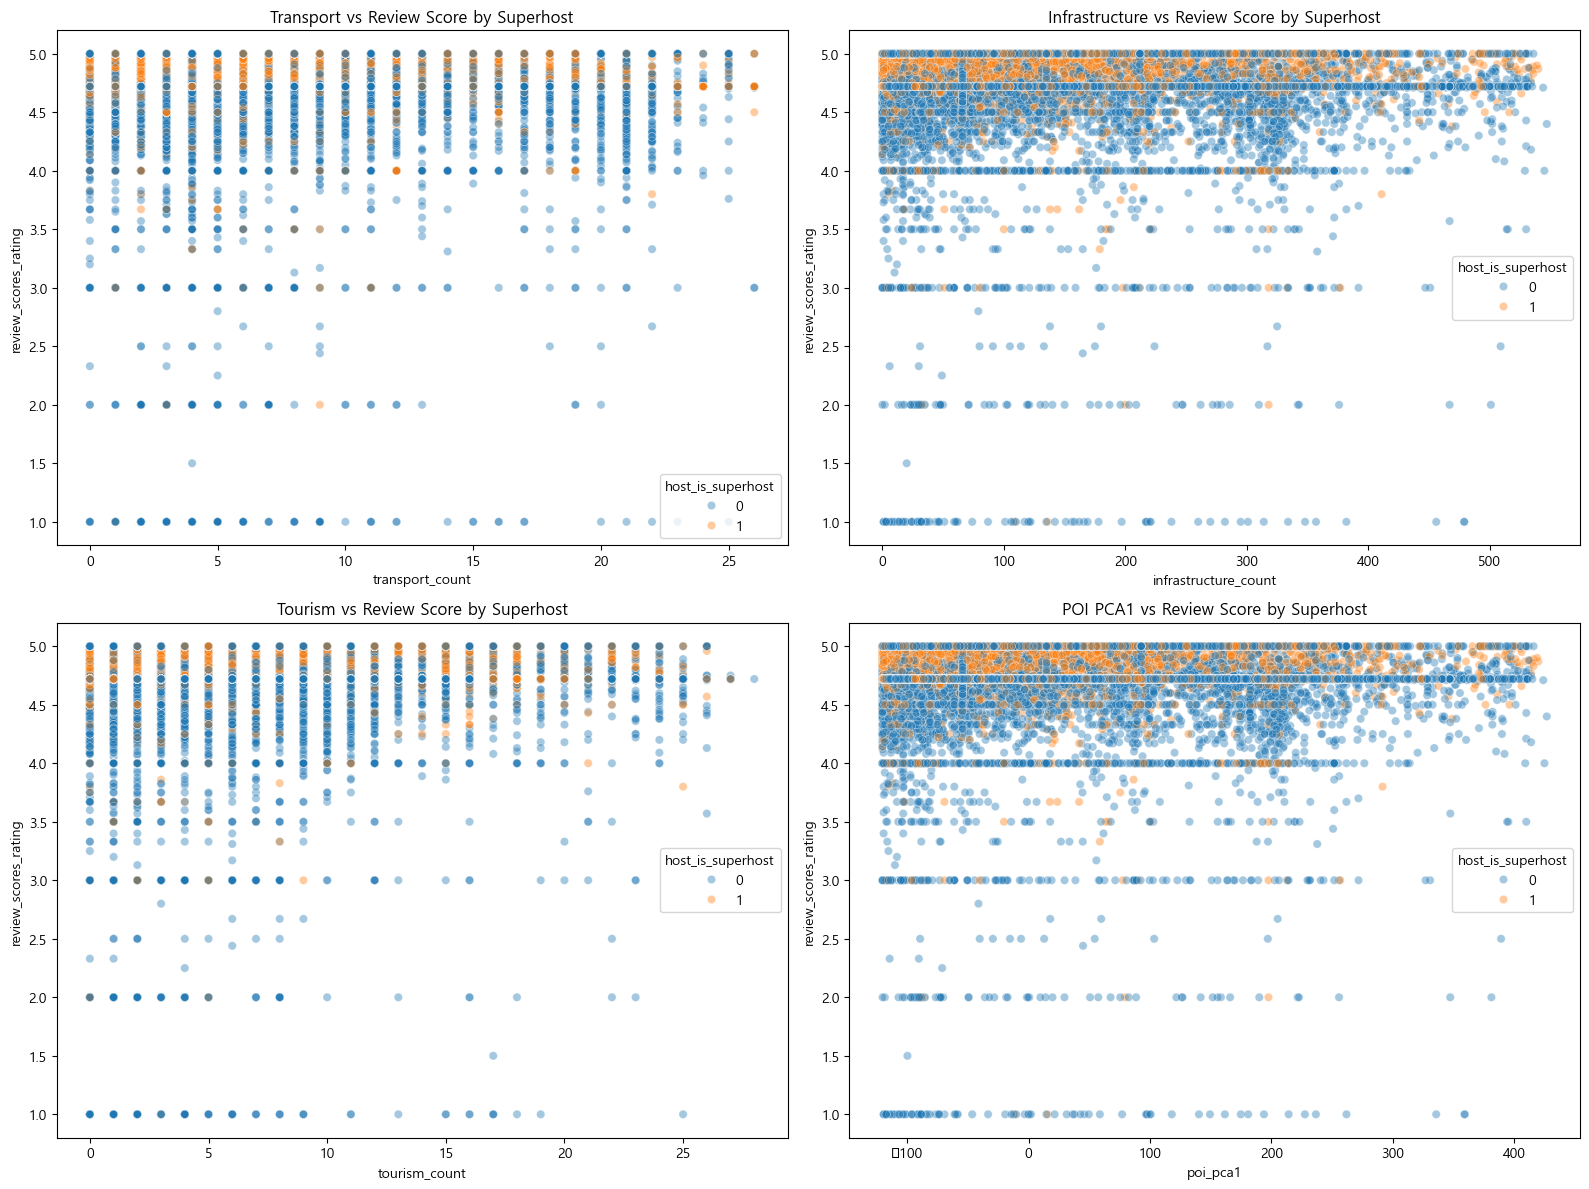

In [67]:
# 인프라가 조금 부족하더라도 서비스가 좋고 리뷰가 좋아서 슈퍼호스트가 되는 경우
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

plot_vars = [
    ('transport_count', 'Transport vs Review Score by Superhost'),
    ('infrastructure_count', 'Infrastructure vs Review Score by Superhost'),
    ('tourism_count', 'Tourism vs Review Score by Superhost'),
    ('poi_pca1', 'POI PCA1 vs Review Score by Superhost')
]

for i, (x_var, title) in enumerate(plot_vars):
    sns.scatterplot(
        data=df,
        x=x_var,
        y='review_scores_rating',
        hue='host_is_superhost',
        alpha=0.4,
        ax=axes[i]
    )
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

In [22]:
# price 정규성 검정
price_data = df['price'].dropna()

stat, p = stats.shapiro(price_data)

print(f"Shapiro-Wilk 통계량: {stat:.4f}") #실제 데이터가 정규분포에 얼마나 가까운지를 수치화한 값 (0~1 사이)
print(f"p-value: {p:.4f}")
if p > 0.05:
    print("정규성을 가정할 수 없다")
else:
    print("정규성을 가정할 수 없다")


Shapiro-Wilk 통계량: 0.2379
p-value: 0.0000
정규성을 가정할 수 없다


c:\Users\HY\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22308.
  res = hypotest_fun_out(*samples, **kwds)


In [23]:
#로그변환 

log_price = np.log1p(df['price'].dropna())  # log(1 + price)로 0도 처리 가능
stat, p = stats.shapiro(log_price)

print(f"Shapiro-Wilk 통계량: {stat:.4f}")
print(f"p-value: {p:.4f}")

if p > 0.05:
    print("로그 변환 후 정규성을 가정할 수 있다")
else:
    print("로그 변환 후에도 정규성을 가정할 수 없다")

Shapiro-Wilk 통계량: 0.9811
p-value: 0.0000
로그 변환 후에도 정규성을 가정할 수 없다


In [24]:
# price Mann-Whitney U 검정 
from scipy.stats import mannwhitneyu

group1 = df[df['host_is_superhost'] == 1]['price'].dropna()
group0 = df[df['host_is_superhost'] == 0]['price'].dropna()

stat, p = mannwhitneyu(group1, group0, alternative='two-sided')
print(f"Mann-Whitney U 통계량: {stat:.4f}, p-value: {p:.4f}")

# 슈퍼호스트인지 아닌지 두그룹의 가격 분포에 차이가 있다

Mann-Whitney U 통계량: 45228149.5000, p-value: 0.0000


In [25]:
#수치형 변수/ 이진형/ 범주형 각각 t검정, 비모수검정, 카이제곱 검정 

from scipy.stats import shapiro, ttest_ind, mannwhitneyu, chi2_contingency
import pingouin as pg   # 카이-제곱용

TARGET = 'host_is_superhost'

# 수치형 변수 리스트 (위도·경도·식별자 제외)
raw_num = [c for c in df.select_dtypes(include=['int64','float64']).columns
           if c not in ['latitude','longitude','host_id','id','host_is_superhost','Unnamed: 0']]

# 이진 수치형(0/1)만 골라내기
binary_num = [c for c in raw_num if df[c].dropna().isin([0,1]).all()]
continuous_num = [c for c in raw_num if c not in binary_num]

# 범주형 변수
cat_cols = df.select_dtypes(include=['object','category']).columns

results = []

# 연속형: 정규성 → t vs Mann-Whitney
def check_normality(series):
    return shapiro(series.dropna())[1] >= 0.05

for col in continuous_num:
    super = df[df[TARGET]==1][col].dropna()
    non   = df[df[TARGET]==0][col].dropna()
    
    if check_normality(super) and check_normality(non):
        stat, p = ttest_ind(super, non, equal_var=False)
        test = 't-test'
    else:
        stat, p = mannwhitneyu(super, non, alternative='two-sided')
        test = 'Mann-Whitney U'
    
    results.append({'variable':col, 'test':test, 'p':round(p,4)})

# 이진 수치형 & 범주형 → 카이제곱
for col in binary_num + cat_cols.tolist():
    ct = pd.crosstab(df[col], df[TARGET])
    chi2, p, _, _ = chi2_contingency(ct)
    results.append({'variable':col, 'test':'chi2', 'p':round(p,4)})

# 결과 정리
stat_df = pd.DataFrame(results).sort_values('p')
stat_df

c:\Users\HY\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6135.
  res = hypotest_fun_out(*samples, **kwds)


,variable,test,p
0,price,Mann-Whitney U,0.0000
1,estimated_occupancy_l365d,Mann-Whitney U,0.0000
2,estimated_revenue_l365d,Mann-Whitney U,0.0000
3,availability_60,Mann-Whitney U,0.0000
4,availability_365,Mann-Whitney U,0.0000
5,amenities_cnt,Mann-Whitney U,0.0000
9,number_of_reviews,Mann-Whitney U,0.0000
8,beds,Mann-Whitney U,0.0000
12,review_scores_rating,Mann-Whitney U,0.0000
13,review_scores_accuracy,Mann-Whitney U,0.0000


슈퍼호스트인지 아닌지는 accommodates(수용인원)과 host_identity_verified(호스트신원확인유무)와 관계없다 
귀무가설 기각하지 못함

In [26]:
#중앙값은 같음= 2
superhost_median = df[df['host_is_superhost'] == 1]['accommodates'].mean().round(2)
non_superhost_median = df[df['host_is_superhost'] == 0]['accommodates'].mean().round(2)

print(f"슈퍼호스트 중앙값: {superhost_median}")
print(f"일반 호스트 중앙값: {non_superhost_median}")

슈퍼호스트 중앙값: 2.86
일반 호스트 중앙값: 2.94


In [27]:
superhost_median = df[df['host_is_superhost'] == 1]['price'].median()
non_superhost_median = df[df['host_is_superhost'] == 0]['price'].median()

print(f"슈퍼호스트 중앙값: {superhost_median}")
print(f"일반 호스트 중앙값: {non_superhost_median}")

# 슈퍼호스트 중앙값이 더 낮다. 합리적인 가격이 슈퍼호스트가 되기에 유리하다값이 나옴 

슈퍼호스트 중앙값: 129.0
일반 호스트 중앙값: 147.0


In [28]:
# 수치형연속형번수만 
continuous_cols = [
    c for c in df.select_dtypes(include=['int64', 'float64']).columns
    if c not in [
        'host_is_superhost', # 종속변수
        'latitude', 'longitude', 'host_id', 'id', 'Unnamed: 0',
        # 이진 0/1 변수들 추가
        'host_identity_verified', 'host_location_boolean', 'host_location_ny',
        'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
        'is_activate', 'host_has_profile_pic','accommodates']]

# 중앙값 테이블
median_table = pd.DataFrame({
    'variable': continuous_cols,
    'superhost_median': [df[df['host_is_superhost'] == 1][col].median() for col in continuous_cols],
    'non_superhost_median': [df[df['host_is_superhost'] == 0][col].median() for col in continuous_cols]})

# 3) 확인
median_table.sort_values('superhost_median', ascending=False)

,variable,superhost_median,non_superhost_median
2,estimated_revenue_l365d,16830.000000,0.000000
4,availability_365,233.000000,270.000000
1,estimated_occupancy_l365d,166.000000,0.000000
0,price,129.000000,147.000000
23,infrastructure_count,63.000000,82.000000
5,amenities_cnt,37.000000,29.000000
3,availability_60,29.000000,53.000000
8,number_of_reviews,22.000000,2.000000
15,review_scores_communication,4.950000,4.810000
14,review_scores_checkin,4.940000,4.830000


In [29]:
# 수치형연속형번수만 
continuous_cols = [
    c for c in df.select_dtypes(include=['int64', 'float64']).columns
    if c not in [
        'host_is_superhost', # 종속변수
        'latitude', 'longitude', 'host_id', 'id', 'Unnamed: 0',
        # 이진 0/1 변수들 추가
        'host_identity_verified', 'host_location_boolean', 'host_location_ny',
        'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
        'is_activate', 'host_has_profile_pic','accommodates']]

# 평균값 테이블 
avg_table = pd.DataFrame({
    'variable': continuous_cols,
    'superhost_avg': [df[df['host_is_superhost'] == 1][col].mean().round(2) for col in continuous_cols],
    'non_superhost_avg': [df[df['host_is_superhost'] == 0][col].mean().round(2) for col in continuous_cols]})

# 3) 확인
avg_table.sort_values('superhost_avg', ascending=False)

,variable,superhost_avg,non_superhost_avg
2,estimated_revenue_l365d,23350.91,7558.93
4,availability_365,219.54,247.38
0,price,178.78,227.13
1,estimated_occupancy_l365d,141.79,44.92
23,infrastructure_count,100.54,127.65
8,number_of_reviews,55.23,26.43
5,amenities_cnt,36.41,28.51
3,availability_60,29.06,38.86
9,number_of_reviews_ltm,11.69,4.03
22,transport_count,5.15,6.37


In [30]:
# 숫자형 데이터 변수 
# 평균 + 중앙값 테이블 합치기
merged_table = pd.merge(
    avg_table,
    median_table,
    on='variable'
)

# 차이 컬럼 추가
merged_table['mean_diff'] = (merged_table['superhost_avg'] - merged_table['non_superhost_avg']).round(2)
merged_table['median_diff'] = (merged_table['superhost_median'] - merged_table['non_superhost_median']).round(2)

# 차이 기준 정렬 
merged_table.sort_values('mean_diff', ascending=False)

,variable,superhost_avg,non_superhost_avg,superhost_median,non_superhost_median,mean_diff,median_diff
2,estimated_revenue_l365d,23350.91,7558.93,16830.000000,0.000000,15791.98,16830.00
1,estimated_occupancy_l365d,141.79,44.92,166.000000,0.000000,96.87,166.00
8,number_of_reviews,55.23,26.43,22.000000,2.000000,28.80,20.00
5,amenities_cnt,36.41,28.51,37.000000,29.000000,7.90,8.00
9,number_of_reviews_ltm,11.69,4.03,3.000000,0.000000,7.66,3.00
20,host_acceptance_rate_score,3.73,3.43,4.000000,4.000000,0.30,0.00
10,number_of_reviews_l30d,0.53,0.24,0.000000,0.000000,0.29,0.00
19,host_response_rate_score,3.99,3.80,4.000000,4.000000,0.19,0.00
11,review_scores_rating,4.84,4.68,4.880000,4.720000,0.16,0.16
17,review_scores_value,4.73,4.57,4.780000,4.610000,0.16,0.17


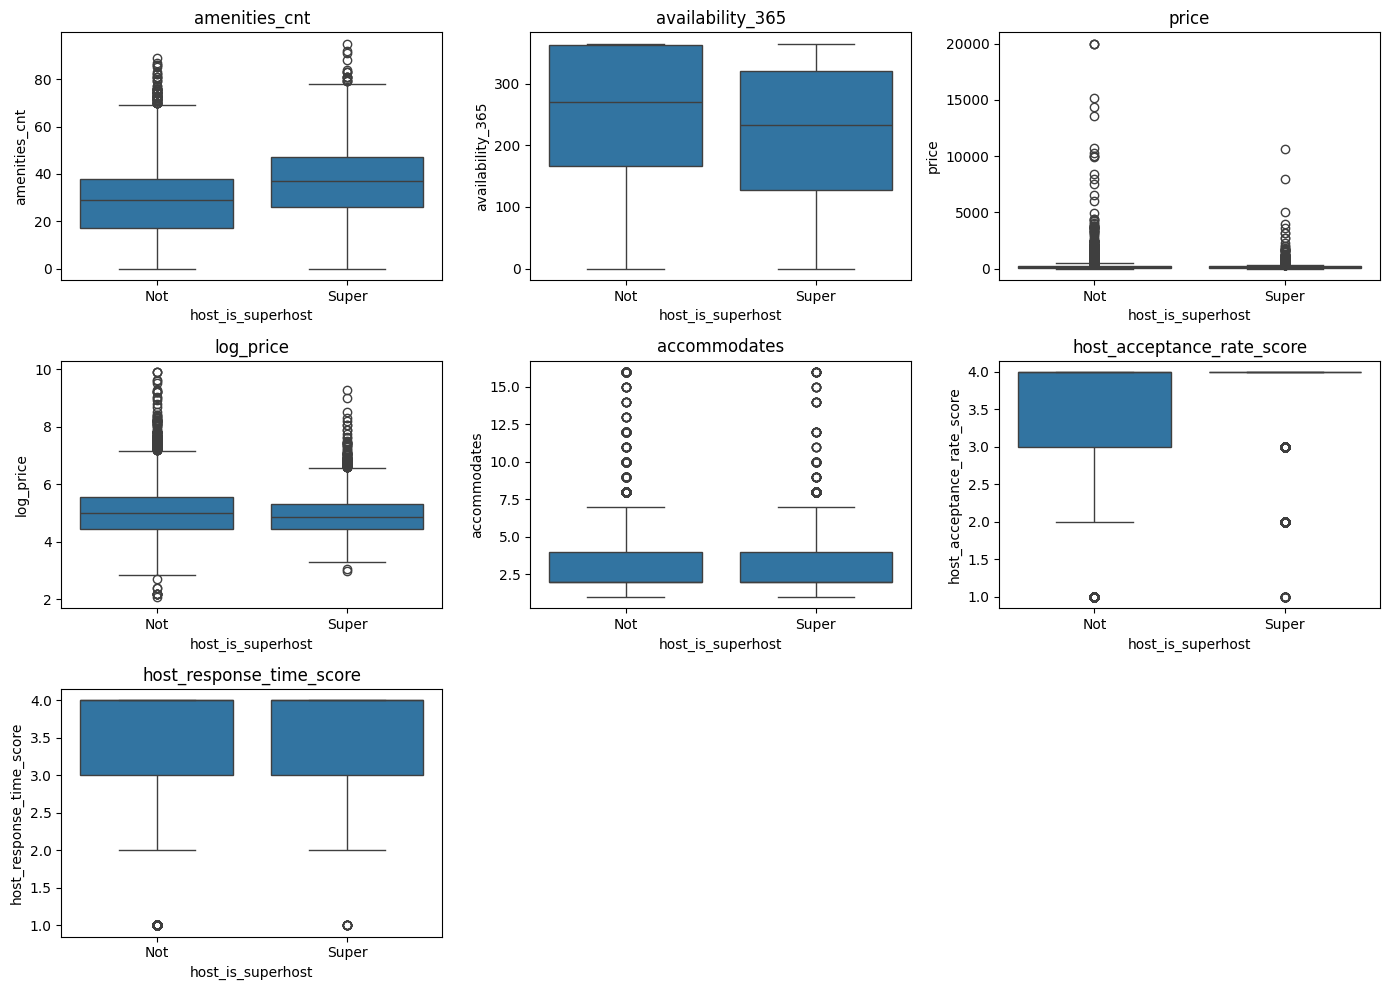

In [31]:
# 수치형 데이터(이진제외)시각화
import seaborn as sns
import matplotlib.pyplot as plt

continuous_cols = [
    'amenities_cnt', 'availability_365', 'price', 'log_price',
    'accommodates', 'host_acceptance_rate_score', 'host_response_time_score'
]

plt.figure(figsize=(14, 10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='host_is_superhost', y=col, data=df)
    plt.title(col)
    plt.xticks([0, 1], ['Not', 'Super'])
plt.tight_layout()
plt.show()

In [32]:
# 이진수치형 데이터 변수
bin_vars = ['host_location_boolean', 'host_location_ny',
        'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
        'is_activate', 'host_has_profile_pic'] 
# 비교 테이블 생성
bin_table = pd.DataFrame({'variable': bin_vars,
    'superhost_ratio(%)': [df[df['host_is_superhost'] == 1][col].mean().round(2) * 100 for col in bin_vars],
    'non_superhost_ratio(%)': [df[df['host_is_superhost'] == 0][col].mean().round(2) * 100 for col in bin_vars]})

# 차이 컬럼 추가
bin_table['ratio_diff(%)'] = (bin_table['superhost_ratio(%)'] - bin_table['non_superhost_ratio(%)']).round(2)

# 정렬 (차이 큰 순서)
bin_table = bin_table.sort_values('ratio_diff(%)', ascending=False)

# 확인
bin_table

# 변수가 1일때 슈퍼호스트와 비슈퍼호스트 비율
# is_activate 활성숙소가 슈퍼호스트는 87% 비슈퍼호스트는 62%
# 브루클린에 사는 호스트중 비 슈퍼호스트는 74% 슈퍼호스트는 80%
# 숙소주변 소개글이 있는 걸로 비율계산 해서 슈퍼호스트는 61% 비 슈퍼 호스트는 53%

,variable,superhost_ratio(%),non_superhost_ratio(%),ratio_diff(%)
5,is_activate,87.0,62.0,25.0
2,neighborhood_overview_exists,61.0,53.0,8.0
1,host_location_ny,74.0,66.0,8.0
0,host_location_boolean,81.0,75.0,6.0
6,host_has_profile_pic,99.0,96.0,3.0
4,instant_bookable,20.0,28.0,-8.0
3,is_long_term,71.0,84.0,-13.0


In [33]:
bin_table = pd.DataFrame({'variable': bin_vars,
    'superhost_1(%)': [df[df['host_is_superhost']==1][col].mean().round(2)*100 for col in bin_vars],
    'superhost_0(%)': [(1-df[df['host_is_superhost']==1][col]).mean().round(2)*100 for col in bin_vars],
    'non_superhost_1(%)': [df[df['host_is_superhost']==0][col].mean().round(2)*100 for col in bin_vars],
    'non_superhost_0(%)': [(1-df[df['host_is_superhost']==0][col]).mean().round(2)*100 for col in bin_vars],
    'diff_1(%)': [df[df['host_is_superhost']==1][col].mean().round(2)*100 -
                 df[df['host_is_superhost']==0][col].mean().round(2)*100 for col in bin_vars]})

bin_table = bin_table.sort_values('diff_1(%)', ascending=False)
bin_table

,variable,superhost_1(%),superhost_0(%),non_superhost_1(%),non_superhost_0(%),diff_1(%)
5,is_activate,87.0,13.0,62.0,38.0,25.0
2,neighborhood_overview_exists,61.0,39.0,53.0,47.0,8.0
1,host_location_ny,74.0,26.0,66.0,34.0,8.0
0,host_location_boolean,81.0,19.0,75.0,25.0,6.0
6,host_has_profile_pic,99.0,1.0,96.0,4.0,3.0
4,instant_bookable,20.0,80.0,28.0,72.0,-8.0
3,is_long_term,71.0,29.0,84.0,16.0,-13.0


In [34]:
df

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,host_response_rate_score,host_acceptance_rate_score,host_location_ny,host_location_boolean,log_price,room_new_type,transport_count,infrastructure_count,tourism_count,poi_pca1
id,,,,,,,,,,,,,,,,,,,,,
36121,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,4,4,1,1,5.303305,mid,7,77,1,-43.212169
36647,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,4,4,1,1,4.418841,upper-mid,3,79,4,-41.262176
38663,Boerum Hill,Brooklyn,40.684420,-73.980680,765.0,0,0.0,49,326,0,...,4,2,1,1,6.641182,low-mid,11,109,2,-11.076188
38833,Harlem,Manhattan,40.818058,-73.946671,139.0,255,35445.0,18,25,0,...,4,4,1,1,4.941642,low-mid,4,34,2,-86.239807
39282,Williamsburg,Brooklyn,40.710651,-73.950874,130.0,154,20020.0,22,38,0,...,4,4,1,1,4.875197,mid,7,117,1,-3.255546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366333532374850165,Harlem,Manhattan,40.813794,-73.952399,72.0,0,0.0,53,358,0,...,4,4,1,1,4.290459,mid,4,58,4,-62.204411
1366717321390111215,Bedford-Stuyvesant,Brooklyn,40.685500,-73.919510,58.0,0,0.0,58,363,0,...,4,4,1,1,4.077537,mid,4,27,1,-93.262927
1366721904709517353,Kips Bay,Manhattan,40.745290,-73.979380,299.0,0,0.0,39,99,0,...,4,4,0,1,5.703782,mid,8,276,6,155.760579


범주형 데이터 - 
'neighbourhood_cleansed','neighbourhood_group_cleansed','structure_type','room_new_type','name_length_group','description_length_group','host_about_length_group' 

In [35]:
cat_var_room_new_type = 'room_new_type'
ct = pd.crosstab(df[cat_var_room_new_type], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
room_new_type,,
high,4.6,1.6
low-mid,12.6,17.8
mid,75.3,72.2
upper-mid,7.5,8.3


In [36]:
#범주형변수 룸타입 
cat_var_room = 'room_type'
ct = pd.crosstab(df[cat_var_room], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)
# 비슈퍼호스트일때와 슈퍼호스트일때 룸타입별 비율 

host_is_superhost,0,1
room_type,,
Entire home/apt,56.1,58.7
Hotel room,2.3,0.0
Private room,41.3,40.8
Shared room,0.4,0.5


In [37]:
cat_var_name = 'name_length_group'
ct = pd.crosstab(df[cat_var_name], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
name_length_group,,
long,47.8,53.2
short_or_med,52.2,46.8


In [38]:
cat_var_description = 'description_length_group'
ct = pd.crosstab(df[cat_var_description], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
description_length_group,,
empty,2.1,1.1
long,54.3,65.1
short_or_avg,43.6,33.8


In [39]:
cat_var_hostabout = 'host_about_length_group'
ct = pd.crosstab(df[cat_var_hostabout], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
host_about_length_group,,
empty,41.7,35.5
long,48.3,54.5
short_or_med,10.1,10.0


In [40]:
cat_var_structure = 'room_structure_type'
ct = pd.crosstab(df[cat_var_structure], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
room_structure_type,,
aparthotel,0.2,0.3
barn,0.0,0.0
bed and breakfast,0.3,0.3
boat,0.0,0.0
boutique hotel,1.2,0.2
bungalow,0.1,0.1
camper/rv,0.1,0.0
casa particular,0.2,0.2
condo,4.3,5.6


In [41]:
cat_var_neighbourhood = 'neighbourhood_cleansed'
ct = pd.crosstab(df[cat_var_neighbourhood], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
neighbourhood_cleansed,,
Allerton,0.1,0.3
Arden Heights,0.0,0.0
Arrochar,0.0,0.0
Arverne,0.3,0.4
Astoria,1.2,1.7
...,...,...
Windsor Terrace,0.2,0.3
Woodhaven,0.3,0.4
Woodlawn,0.0,0.1


In [42]:
cat_var_group = 'neighbourhood_group_cleansed'
ct = pd.crosstab(df[cat_var_group], df['host_is_superhost'], normalize='columns') * 100
ct.round(1)

host_is_superhost,0,1
neighbourhood_group_cleansed,,
Bronx,4.1,4.0
Brooklyn,31.3,38.9
Manhattan,48.8,37.6
Queens,14.4,17.8
Staten Island,1.3,1.8


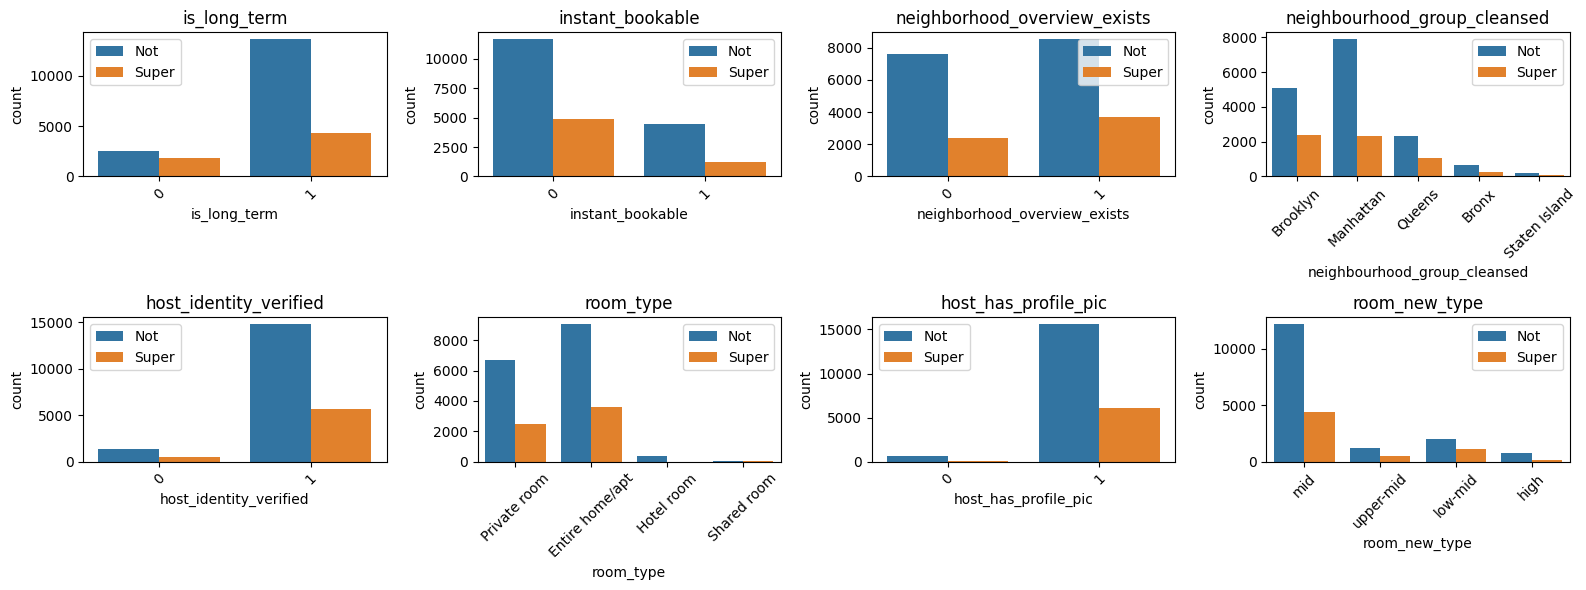

In [ ]:
# 범주형/ 이진형 데이터 시각화 
cat_cols = [
    'is_long_term', 'instant_bookable', 'neighborhood_overview_exists',
    'neighbourhood_group_cleansed', 'host_identity_verified',
    'room_type', 'host_has_profile_pic', 'room_new_type']

n_cols = 4
n_rows = (len(cat_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(16, 3 * n_rows))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(x=col, hue='host_is_superhost', data=df)
    plt.title(col)
    plt.legend(title=None, labels=['Not', 'Super'])
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
# 제외할 칼럼
exclude_cols = ['host_id', 'id', 'latitude', 'longitude', 'host_is_superhost']

# 이진 수치형 변수 'host_identity_verified'귀무가설 기각 못해서 제외함
bin_vars = ['host_location_boolean', 'host_location_ny',
        'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
        'is_activate', 'host_has_profile_pic'] 

# 전체 수치형 변수에서 이진 변수 제외
numeric_vars = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                if col not in exclude_cols + bin_vars]

# 범주형 변수
categorical_vars = df.select_dtypes(include='object').columns.tolist()

# X, y 설정
X = df[numeric_vars + bin_vars + categorical_vars + [TARGET]].copy()
y = X.pop(TARGET).astype(int) 

# 인코딩위해서 범주형과 숫자형(이진,숫자)으로 나누기 
cat_cols = [c for c in X.columns if X[c].dtype == 'object']   # 문자만
num_cols = [c for c in X.columns if X[c].dtype != 'object'] 

# 학습,테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# 제외할 칼럼 및 이진 변수 지정
exclude_cols = ['host_id', 'id', 'latitude', 'longitude', 'host_is_superhost']
bin_vars = ['host_location_boolean', 'host_location_ny',
            'neighborhood_overview_exists', 'is_long_term', 'instant_bookable',
            'is_activate', 'host_has_profile_pic']

# 수치형 / 범주형 변수 지정
numeric_vars = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                if col not in exclude_cols + bin_vars]
categorical_vars = df.select_dtypes(include='object').columns.tolist()

# X, y 분리
TARGET = 'host_is_superhost'
X = df[numeric_vars + bin_vars + categorical_vars + [TARGET]].copy()
y = X.pop(TARGET).astype(int)

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# -----------------------
# 1. ColumnTransformer 설정
# -----------------------

# 여기 sparse_output=True로 변경 (메모리 절약)
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_vars),
    ('bin', 'passthrough', bin_vars)], remainder='drop', verbose_feature_names_out=False)
# .set_output(transform='pandas') →  제거 (sparse matrix와 pandas는 호환 안 됨)

# -----------------------
# 2. 사용할 모델들 정의
# -----------------------
models = {'Logistic': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced'),}

# -----------------------
# 3. 모델 학습 및 평가
# -----------------------
for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocessor),('classifier', clf)])

    # 학습
    pipe.fit(X_train, y_train)

    # 예측
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    # 평가
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("AUC:", round(roc_auc_score(y_test, y_prob), 4))


=== Logistic ===
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      3235
           1       0.60      0.75      0.66      1227

    accuracy                           0.79      4462
   macro avg       0.75      0.78      0.76      4462
weighted avg       0.81      0.79      0.80      4462

AUC: 0.8596

=== RandomForest ===
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3235
           1       0.82      0.63      0.71      1227

    accuracy                           0.86      4462
   macro avg       0.84      0.79      0.81      4462
weighted avg       0.86      0.86      0.85      4462

AUC: 0.9172


로지스틱 정확도 AUC : 79%  0.8582
랜덤포레스트 정확도 AUC : 86%  0.9165

F1-score는 로지스틱과 랜덤포레스트 모두 일반호스트예측이 높고 슈퍼호스트는 낮은편 그래도 랜덤포레스트가 두가지다 높은편

| 목적             | 사용 변수      | 모델링 목표                      |
| -------------- | ---------- | --------------------------- |
| **연관성 탐색 모델링** | 전체 변수(일부제외)   | “슈퍼호스트는 어떤 특성을 갖고 있을까?”     |
**전략 모델링**     | 전략가능 변수만 | “어떻게 하면 슈퍼호스트가 될 수 있을까?” |

In [60]:
# 연관성탐색 모델링부터 랜덤포레스트로 다시 
exclude_cols = ['host_is_superhost', 'amenities', 'host_id','longitude','latitude']
# 종속변수 제외한 전체 컬럼
cols = [c for c in df.columns if c not in exclude_cols ]
X = df[cols]
X = pd.get_dummies(X, drop_first=True)
y = df['host_is_superhost']
# 학습/테스트 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 학습
rf = RandomForestClassifier(n_estimators=300, random_state=42).fit(X_train, y_train)

# 변수 중요도
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("\n=== 변수 중요도 ===")
importances.sort_values(ascending=False).round(2)



=== 변수 중요도 ===


estimated_revenue_l365d                   0.05
number_of_reviews_ltm                     0.05
estimated_occupancy_l365d                 0.05
amenities_cnt                             0.04
review_scores_rating                      0.04
                                          ... 
neighbourhood_cleansed_Todt Hill          0.00
room_structure_type_religious building    0.00
room_structure_type_kezhan                0.00
neighbourhood_cleansed_Oakwood            0.00
room_structure_type_barn                  0.00
Length: 305, dtype: float64

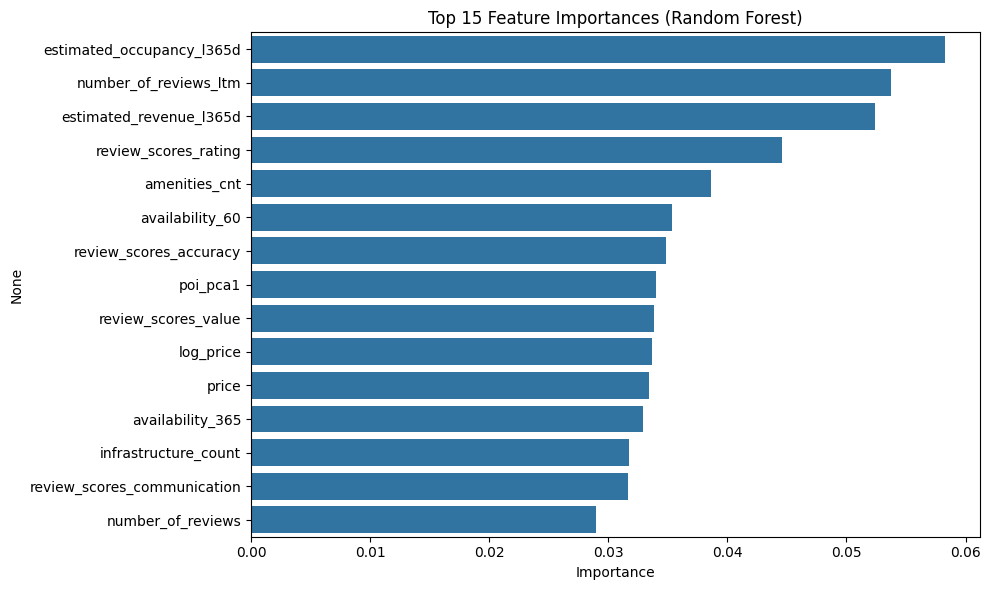

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

top_importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_importances.index)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [46]:
# 연관성탐색에서 변수중요도 기준으로 전략모델링 랜덤포레스트 
strategy_cols = ['amenities_cnt','availability_365','log_price','price','host_response_time_score','host_acceptance_rate_score','instant_bookable','host_about_length_group','room_type',
'neighbourhood_group_cleansed','host_has_profile_pic','neighborhood_overview_exists','name_length_group','description_length_group','is_long_term','accommodates','host_identity_verified','room_new_type']
# 중요 변수만 선택해서 전략 모델용 데이터셋 구성
X_top = df[strategy_cols]
X_top_encoded = pd.get_dummies(X_top)
# 학습/테스트 분할
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top_encoded, y, test_size=0.2, random_state=42, stratify=y)

# 랜덤포레스트로 학습 (전략 모델)
rf_top = RandomForestClassifier(n_estimators=300, random_state=42)
rf_top.fit(X_train_top, y_train_top)
# 평가 지표
y_pred_top = rf_top.predict(X_test_top)
y_proba_top = rf_top.predict_proba(X_test_top)[:, 1]

print("\n=== 전략 모델 성능 평가 (중요 변수만) ===")
print(classification_report(y_test_top, y_pred_top))
print("AUC:", roc_auc_score(y_test_top, y_proba_top))

# 변수 중요도
importances2 = pd.Series(rf_top.feature_importances_, index=X_top_encoded.columns)
print("\n=== 변수 중요도 ===")
importances2.sort_values(ascending=False).round(2)


=== 전략 모델 성능 평가 (중요 변수만) ===
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      3235
           1       0.77      0.52      0.62      1227

    accuracy                           0.83      4462
   macro avg       0.80      0.73      0.76      4462
weighted avg       0.82      0.83      0.81      4462

AUC: 0.8891841097208735

=== 변수 중요도 ===


amenities_cnt                                 0.16
availability_365                              0.14
price                                         0.12
log_price                                     0.12
accommodates                                  0.05
host_acceptance_rate_score                    0.05
host_response_time_score                      0.04
is_long_term                                  0.03
instant_bookable                              0.02
neighborhood_overview_exists                  0.02
neighbourhood_group_cleansed_Manhattan        0.02
host_about_length_group_long                  0.02
neighbourhood_group_cleansed_Brooklyn         0.02
host_about_length_group_empty                 0.02
room_new_type_mid                             0.01
description_length_group_long                 0.01
description_length_group_short_or_avg         0.01
neighbourhood_group_cleansed_Queens           0.01
name_length_group_long                        0.01
room_type_Entire home/apt      

정확도 : 82%   Location넣어서 모델링하니까 정확도 88%까지 올라감 

AUC : 0.8874 0과 1사이에서 얼마나 잘 구분하는가 ->0.8891 조금 올라감 

recall/ f1-score 슈퍼호스트 잡는 비율이 낮음(재현율) 변화없음 

#그대로 진행 
정밀도 우선: 확신이 있을 때만 슈퍼호스트라고 인정 
슈퍼호스트라고 판단한 사람은 거의 진짜임 (정밀도 82)
하지만 ‘슈퍼호스트 맞는데 확신이 덜해서 못 뽑는 경우’가 많아짐 (재현율 52)

#임계점을 낮춤
재현율 우선: 조금만 “슈퍼호스트일 가능성 있다” 해도 다 슈퍼호스트라고 인정
많은 슈퍼호스트를 잘 찾아냄 (재현율 상승 52에서 83으로 상승함)
하지만 ‘사실은 슈퍼호스트 아닌 사람’도 많이 슈퍼호스트라고 뽑음 (정밀도하락 82에서 79로 하락)

전략인사이트 도출이 메인
변수 중요도가 중요하고, 임계값은 부차적인듯 
일단 정밀도 82와 재현율52(절반이상은 잡아냄)모델 
변수중요도에 있어서는 신뢰할 수준 인듯 


In [47]:
#임계점 낮춤 
threshold = 0.3
y_pred_new = (y_proba_top >= threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test_top, y_pred_new))

# 변수 중요도
importances3 = pd.Series(rf_top.feature_importances_, index=X_top_encoded.columns)
print("\n=== 변수 중요도 ===")
importances3.sort_values(ascending=False).round(2)

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      3235
           1       0.60      0.84      0.70      1227

    accuracy                           0.80      4462
   macro avg       0.76      0.81      0.77      4462
weighted avg       0.84      0.80      0.81      4462


=== 변수 중요도 ===


amenities_cnt                                 0.16
availability_365                              0.14
price                                         0.12
log_price                                     0.12
accommodates                                  0.05
host_acceptance_rate_score                    0.05
host_response_time_score                      0.04
is_long_term                                  0.03
instant_bookable                              0.02
neighborhood_overview_exists                  0.02
neighbourhood_group_cleansed_Manhattan        0.02
host_about_length_group_long                  0.02
neighbourhood_group_cleansed_Brooklyn         0.02
host_about_length_group_empty                 0.02
room_new_type_mid                             0.01
description_length_group_long                 0.01
description_length_group_short_or_avg         0.01
neighbourhood_group_cleansed_Queens           0.01
name_length_group_long                        0.01
room_type_Entire home/apt      

In [48]:
original_cols = ['amenities_cnt','availability_365','price','log_price','accommodates','host_acceptance_rate_score','host_response_time_score','is_long_term','instant_bookable','neighborhood_overview_exists','neighbourhood_group_cleansed',
    'host_about_length_group','description_length_group','name_length_group','host_identity_verified','room_type','host_has_profile_pic','room_new_type']

def find_group(feature_name, original_cols):
    for col in original_cols:
        if feature_name == col or feature_name.startswith(col + '_'):
            return col
    return '기타'

importance_df = importances2.reset_index()
importance_df.columns = ['feature', 'importance']

importance_df['group'] = importance_df['feature'].apply(lambda x: find_group(x, original_cols))

grouped_importance = importance_df.groupby('group')['importance'].sum().sort_values(ascending=False)

grouped_importance.round(2)

group
amenities_cnt                   0.16
availability_365                0.14
price                           0.12
log_price                       0.12
neighbourhood_group_cleansed    0.06
accommodates                    0.05
host_acceptance_rate_score      0.05
host_response_time_score        0.04
host_about_length_group         0.04
room_new_type                   0.04
description_length_group        0.03
room_type                       0.03
is_long_term                    0.03
name_length_group               0.03
instant_bookable                0.02
neighborhood_overview_exists    0.02
host_identity_verified          0.01
host_has_profile_pic            0.00
Name: importance, dtype: float64

중요도를 이전에 인코딩하면서 나뉘었던 변수들을 그룹으로 다시 묶어서 더해지게 계산해봄 
neighbourhood_group_cleansed 같은 경우 그룹으로 묶였을때 더 높아짐 
host_about_length_group이나 description_length_group도 그룹으로 했을때 높아짐 짧고 길고 소개글자체가 슈퍼호스트여부와 확실히 관련이 있다. 

중요도 기반 인사이트

| 순위 | 변수명                                      | 중요도     | 변수 설명          | 전략 방향 및 실행 방법                                                                  |
| -- | ---------------------------------------- | ------- | -------------- | ------------------------------------------------------------------------------ |
| 1  | `amenities_cnt`                          | **0.17**   | 숙소에 등록된 편의시설 수 | 다양한 편의시설 등록 → Wi-Fi, 세탁기, 주방, 냉장고, 에어컨, TV 등 기본 옵션 외에도 **욕실용품, 커피포트, 책상 등 추가** |
| 2  | `availability_365`                       | **0.15**  | 연중 예약 가능 일수    | 실제 일수 평균과 중앙값 비교했을때 슈퍼호스트가 아닌쪽이 더 많이 열려있음 (차이가 있어서 귀무가설은 기각했지만 인사이트적으로는...)                                        |
| 3  | `price` / `log_price`                    | **0.13/0.12** | 숙소 가격 / 로그 가격  | 너무 싸거나 너무 비싸지 않게, **지역 평균가와 비교하여 합리적 가격 설정**                                   |
| 4  | `accommodates`                           | 0.06    | 수용 가능 인원       | 귀무가설 기각못함(중앙값은 같고 평균도 0.1정도 차이로 인사이트내기에는 어려울듯 다른변수랑 더해서 생각)                  |
| 5  | `host_acceptance_rate_score`             | 0.05    | 예약 수락률         | 예약 요청은 **가능한 모두 수락**, 특별 사유가 없다면 거절 자제 (평균만 조금의 차이 중앙값은 같다)                                       |
| 6  | `host_response_time_score`               | 0.05    | 응답 속도 점수       | **24시간 내 응답은 필수**, 가급적 **1시간 이내 빠른 응답** 유지 ((평균만 조금의 차이 중앙값은 같다)                                       |)                                 |
| 7  | `is_long_term`                           | 0.03    | 장기 숙박 가능 여부    | 장기는 슈퍼호스트가 아닌 사람의 비율이 조금더 높고 단기는 슈퍼호스트가 높다 아마 단기로 많이 받는게 리뷰수가 많아질 가능성이 높아서 일듯                                     |
| 8  | `instant_bookable`                       | 0.02    | 즉시 예약 가능 여부    | 슈퍼호스트인 그룹은 0(즉시예약불가)가 80으로 훨씬 많음 1은 20대 즉시예약가능하지않아도 슈퍼호스트되는것에 상관없다                           |
| 9  | `host_about_length_group_long`           | 0.02    | 호스트 소개 글 길이    | **신뢰감 있는 소개글 작성 추천 (100자 이상)**                                       |
| 10 | `name_length_group_short_or_med`         | 0.02    | 숙소 이름 길이       | **짧고 직관적인 이름 설정** (예: Cozy Studio in Brooklyn)                                 |
| 11 | `neighborhood_overview_exists`           | 0.02    | 동네 소개 존재 여부    | **주변 지역 특징, 교통, 맛집, 안전성 등 있는게 유리**                                                 |
| 12 | `room_type_Private room`                 | 0.02    | 개인실 여부         | 비율로 확인했을때 큰차이없음                                           |
| 13 | `neighbourhood_group_cleansed_Manhattan` | 0.02    | 맨해튼 지역 여부      | 위치가 좋은 경우 강조: **‘도보로 \~분’, ‘중심지 위치’ 등 명시**                                     |
| 14 | `neighbourhood_group_cleansed_Brooklyn`  | 0.02    | 브루클린 지역 여부     |                                                |
| 15 | `description_length_group_long`          | 0.01    | 숙소 설명 글 길이     | 상세하게 쓰기: **숙소 구조, 편의시설, 주변시설, 체크인 방법 등 포함**                                    |
| 16 | `host_about_length_group_short_or_med`   | 0.01    | 중·단 소개글        | 장문보다는 낮은 중요도, **정보는 빠짐없이 간결하게**                                                |
| 17 | `description_length_group_short_or_avg`  | 0.01    | 중·단 숙소 설명      | 긴 설명이 더 효과적이므로 보완 필요                                                           |
| 18 | `host_has_profile_pic`                   | 0.01    | 프로필 사진 여부      | 기본이지만 중요함: **신뢰감을 위해 반드시 사진 등록**                                               |
| 19 | `neighbourhood_group_cleansed_Queens`    | 0.01    | 퀸즈 지역 여부       |                                               |
                                     |


'host_identity_verified'/'accommodates' 검정결과는 귀무가설기각 할수없었는데 모델링 과정에서 accommodates가 중요도 높게 나옴 단독으로는 변화가 없지만 다른 변수들과 함께 비교했을때 중요도 상승?
accommodates - 수요에 맞는 인원 설정. **1\~2인실은 깔끔함 강조**, **4인 이상은 가족/단체용으로 옵션 다양화

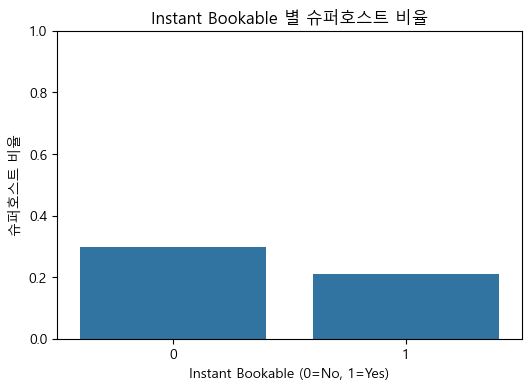

In [49]:
plt.rcParams['font.family'] = 'Malgun Gothic'

# instant_bookable 별 슈퍼호스트 비율 계산
rate_instant = df.groupby('instant_bookable')['host_is_superhost'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='instant_bookable', y='host_is_superhost', data=rate_instant)
plt.xlabel('Instant Bookable (0=No, 1=Yes)')
plt.ylabel('슈퍼호스트 비율')
plt.title('Instant Bookable 별 슈퍼호스트 비율')
plt.ylim(0, 1)
plt.show()

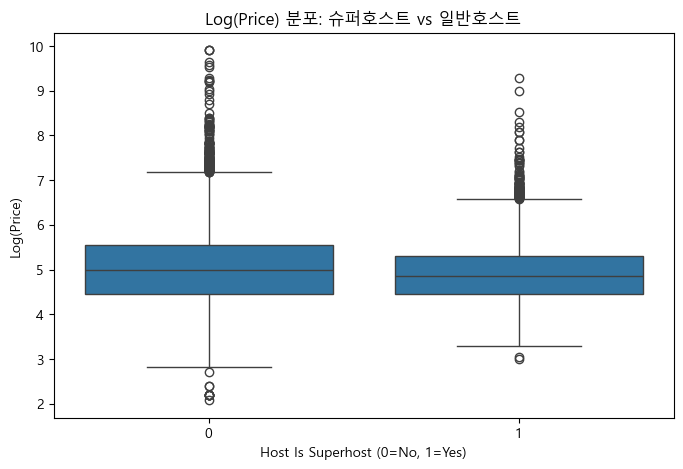

In [50]:
plt.figure(figsize=(8,5))
sns.boxplot(x='host_is_superhost', y='log_price', data=df)
plt.xlabel('Host Is Superhost (0=No, 1=Yes)')
plt.ylabel('Log(Price)')
plt.title('Log(Price) 분포: 슈퍼호스트 vs 일반호스트')
plt.show()

In [51]:
# 1) 통계 결과 DataFrame
merged_table['insight'] = merged_table.apply(
    lambda r: f"슈퍼호스트 평균 {'↑' if r['mean_diff']>0 else '↓'} {abs(r['mean_diff']):.1f}"
    + f" / 중앙값 {'↑' if r['median_diff']>0 else '↓'} {abs(r['median_diff']):.1f}",
    axis=1)

# 2) 중요도 DataFrame
importance_df['insight'] = (
    importance_df['importance'].rank(pct=True)
    .apply(lambda r: f"상위 {r*100:.0f}% 중요도"))

# 3) 두 DataFrame 병합
merged_table[['variable','mean_diff','median_diff','insight']].sort_values('mean_diff', ascending=False)


,variable,mean_diff,median_diff,insight
2,estimated_revenue_l365d,15791.98,16830.00,슈퍼호스트 평균 ↑ 15792.0 / 중앙값 ↑ 16830.0
1,estimated_occupancy_l365d,96.87,166.00,슈퍼호스트 평균 ↑ 96.9 / 중앙값 ↑ 166.0
8,number_of_reviews,28.80,20.00,슈퍼호스트 평균 ↑ 28.8 / 중앙값 ↑ 20.0
5,amenities_cnt,7.90,8.00,슈퍼호스트 평균 ↑ 7.9 / 중앙값 ↑ 8.0
9,number_of_reviews_ltm,7.66,3.00,슈퍼호스트 평균 ↑ 7.7 / 중앙값 ↑ 3.0
20,host_acceptance_rate_score,0.30,0.00,슈퍼호스트 평균 ↑ 0.3 / 중앙값 ↓ 0.0
10,number_of_reviews_l30d,0.29,0.00,슈퍼호스트 평균 ↑ 0.3 / 중앙값 ↓ 0.0
19,host_response_rate_score,0.19,0.00,슈퍼호스트 평균 ↑ 0.2 / 중앙값 ↓ 0.0
11,review_scores_rating,0.16,0.16,슈퍼호스트 평균 ↑ 0.2 / 중앙값 ↑ 0.2
17,review_scores_value,0.16,0.17,슈퍼호스트 평균 ↑ 0.2 / 중앙값 ↑ 0.2
